In [37]:
import pandas as pd

# Step 1: Load the dataset
df = pd.read_csv("online_retail.csv")  # Replace with actual filename

# Step 2: Look at the top rows
print(df.head())

# Step 3: Basic info
print(df.info())

# Step 4: Check for missing values
print(df.isnull().sum())

# Step 5: Check for duplicates
print(df.duplicated().sum())

# Step 6: Quick summary
print(df.describe())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2022-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2022-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       ------------

C:\Users\Admin\AppData\Local\Temp\ipykernel_1172\1146537185.py:63: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


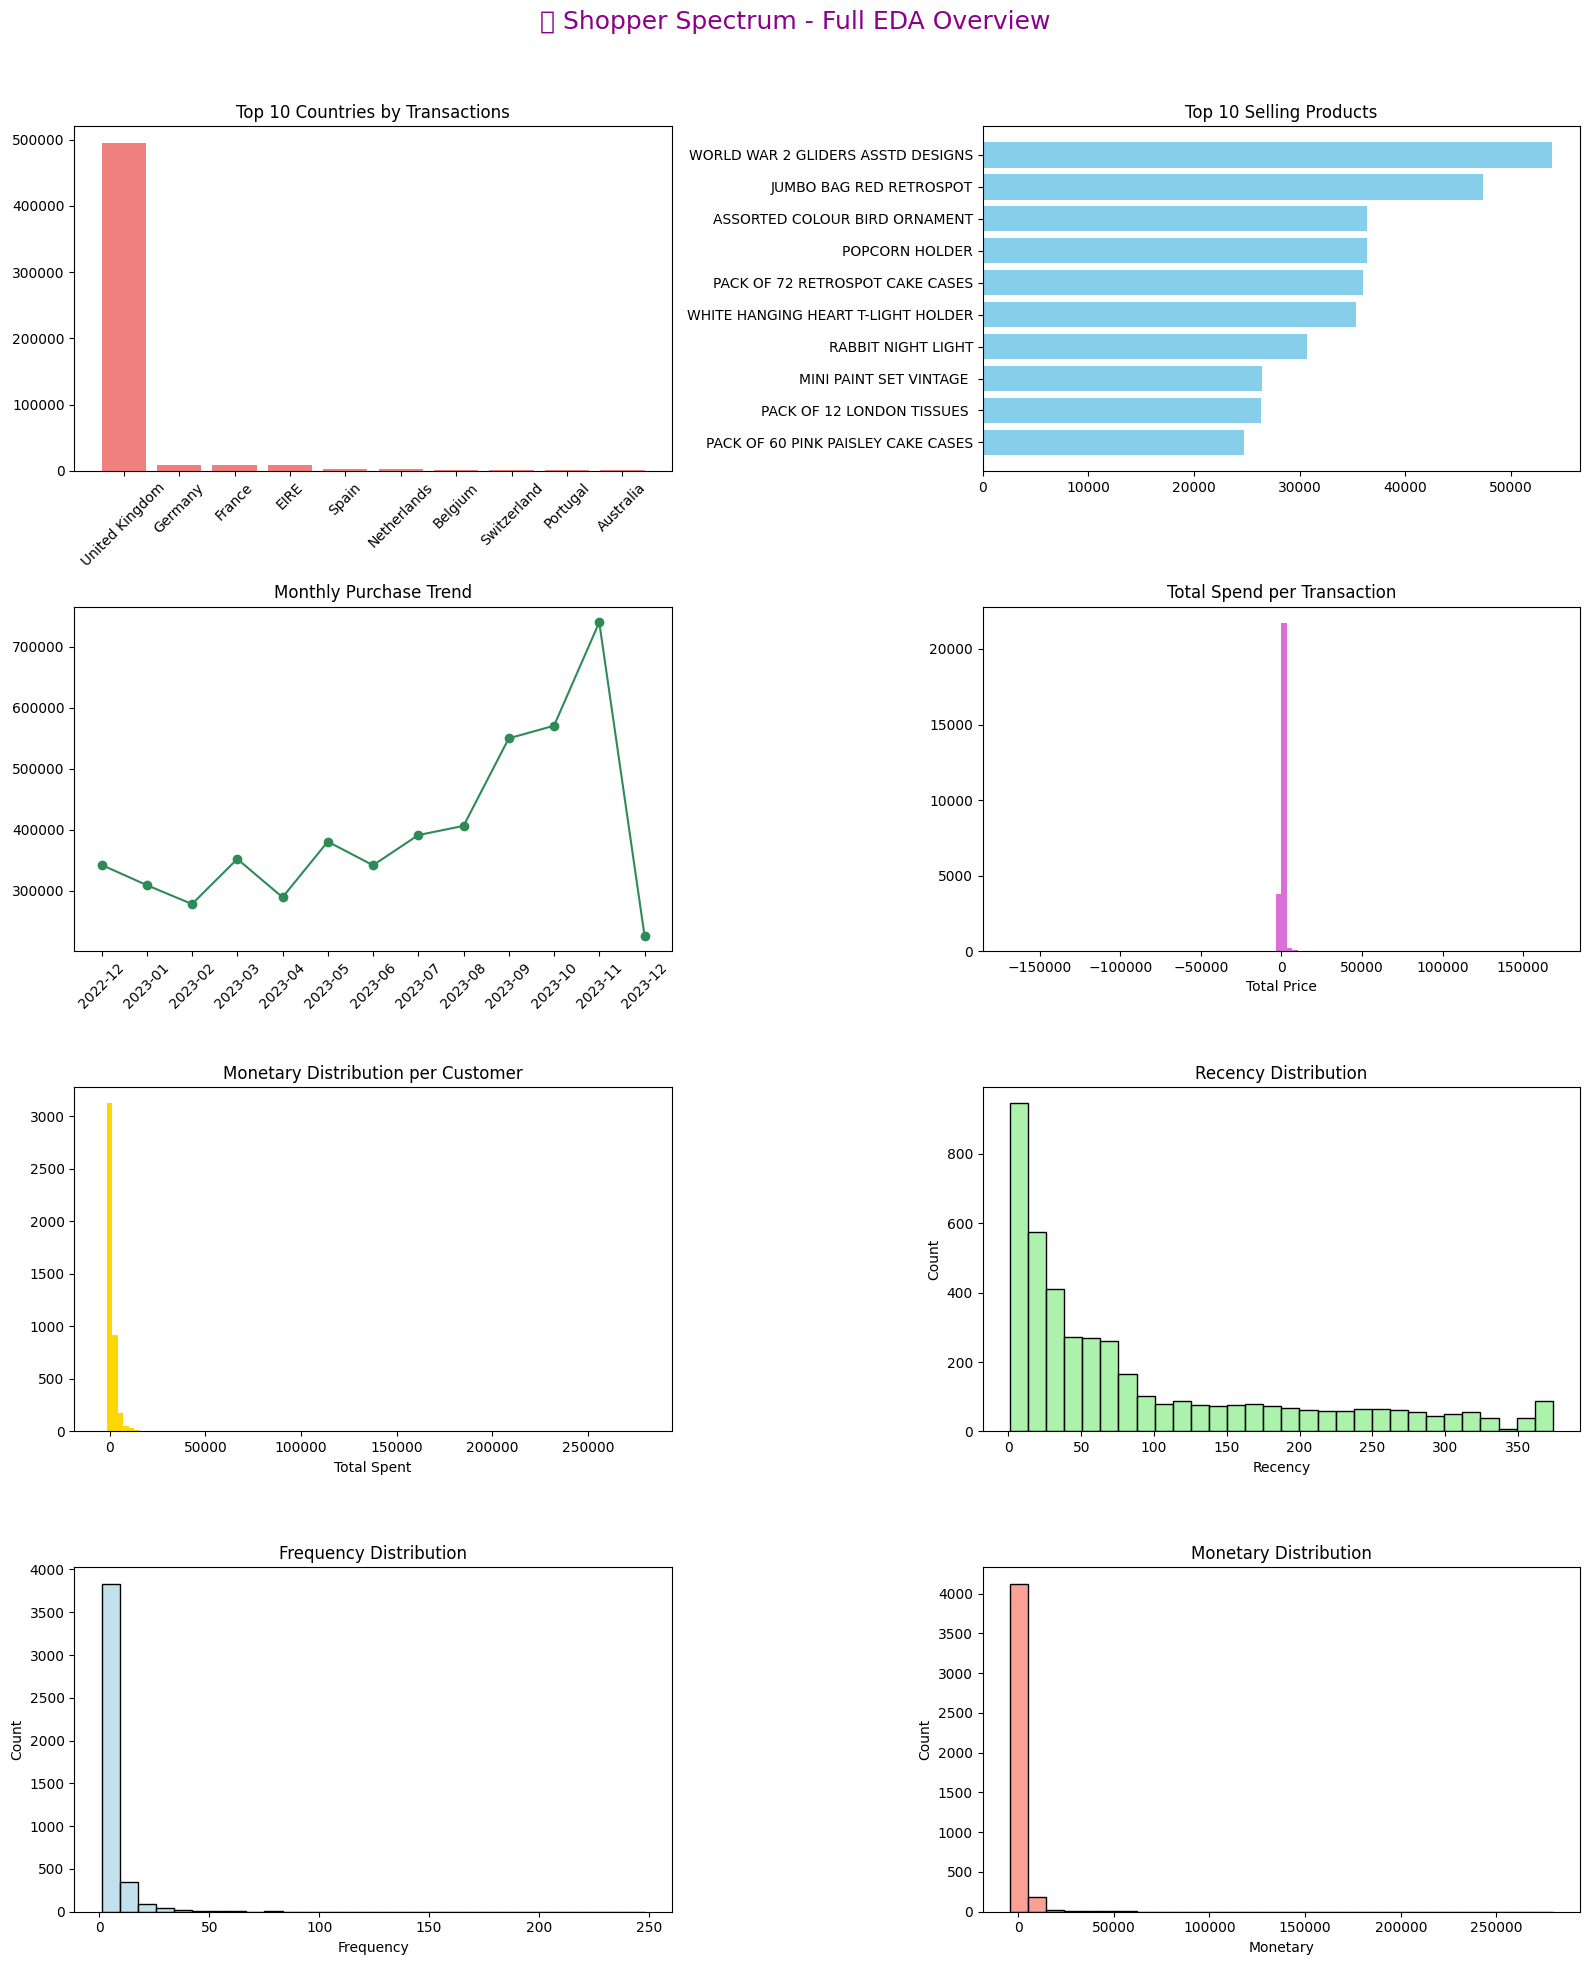

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📌 Make sure these columns exist
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.to_period('M')

# 🔍 Set figure
fig, axs = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle("🛍️ Shopper Spectrum - Full EDA Overview", fontsize=18, color='darkmagenta')

# 1️⃣ Transaction Volume by Country
top_countries = df['Country'].value_counts().head(10)
axs[0, 0].bar(top_countries.index, top_countries.values, color='lightcoral')
axs[0, 0].set_title('Top 10 Countries by Transactions')
axs[0, 0].tick_params(axis='x', rotation=45)

# 2️⃣ Top-Selling Products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
axs[0, 1].barh(top_products.index[::-1], top_products.values[::-1], color='skyblue')
axs[0, 1].set_title('Top 10 Selling Products')

# 3️⃣ Purchase Trend Over Time (Monthly)
monthly_sales = df.groupby('Month')['Quantity'].sum()
axs[1, 0].plot(monthly_sales.index.astype(str), monthly_sales.values, marker='o', color='seagreen')
axs[1, 0].set_title('Monthly Purchase Trend')
axs[1, 0].tick_params(axis='x', rotation=45)

# 4️⃣ Total Spend Distribution per Transaction
transaction_totals = df.groupby('InvoiceNo')['TotalPrice'].sum()
axs[1, 1].hist(transaction_totals, bins=100, color='orchid')
axs[1, 1].set_title('Total Spend per Transaction')
axs[1, 1].set_xlabel('Total Price')

# 5️⃣ Total Spend per Customer
customer_totals = df.groupby('CustomerID')['TotalPrice'].sum()
axs[2, 0].hist(customer_totals, bins=100, color='gold')
axs[2, 0].set_title('Monetary Distribution per Customer')
axs[2, 0].set_xlabel('Total Spent')

# 6️⃣ RFM Distributions
# RFM Calculation
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Plot RFM histograms
sns.histplot(rfm['Recency'], bins=30, ax=axs[2, 1], color='lightgreen')
axs[2, 1].set_title("Recency Distribution")

sns.histplot(rfm['Frequency'], bins=30, ax=axs[3, 0], color='lightblue')
axs[3, 0].set_title("Frequency Distribution")

sns.histplot(rfm['Monetary'], bins=30, ax=axs[3, 1], color='salmon')
axs[3, 1].set_title("Monetary Distribution")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [39]:
from sklearn.preprocessing import StandardScaler

# Create a copy 
rfm_scaled = rfm.copy()

# Initialize scaler
scaler = StandardScaler()

# Fit and transform
rfm_scaled[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm_scaled[['Recency', 'Frequency', 'Monetary']])

# Preview
print(rfm_scaled.head())


             Recency  Frequency  Monetary
CustomerID                               
12346.0     2.322023  -0.329362 -0.231001
12347.0    -0.893733   0.206102  0.293432
12348.0    -0.169196  -0.115176 -0.012316
12349.0    -0.725005  -0.436455 -0.017146
12350.0     2.163220  -0.436455 -0.190312


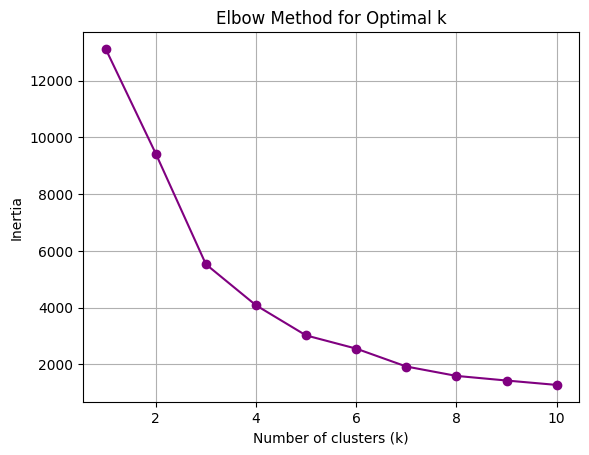

In [40]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try different values of k (1 to 10)
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_range, inertia, marker='o', color='purple')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [41]:
import pickle
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled)

# save the actual model
with open("rfm_kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)


In [42]:
print(rfm.columns)
print(rfm.head())

Index(['Recency', 'Frequency', 'Monetary'], dtype='object')
            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          2      0.00
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40


In [43]:
# Cluster-wise mean
cluster_summary = rfm.groupby('Cluster').mean().round(2)
print(cluster_summary)


KeyError: 'Cluster'

In [29]:
segment_labels = {
    2: 'High-Value',
    0: 'Regular',
    3: 'Occasional',
    1: 'At-Risk'
}

rfm['Segment'] = rfm['Cluster'].map(segment_labels)


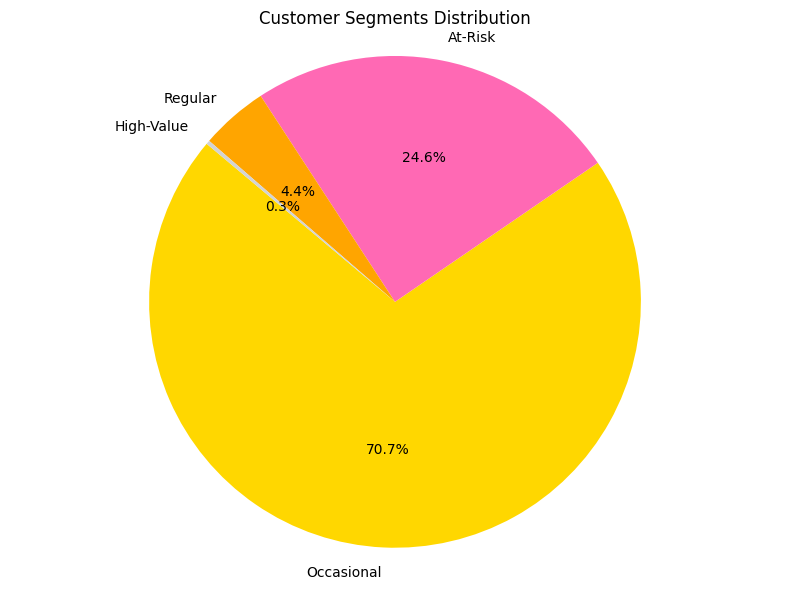

In [30]:
import matplotlib.pyplot as plt

# Count of customers in each segment
segment_counts = rfm['Segment'].value_counts()

# Plotting a pie chart
colors = ['#FFD700', '#FF69B4', '#FFA500', '#D3D3D3']
plt.figure(figsize=(8, 6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Customer Segments Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
#Segment	% of Customers	Meaning
#Occasional	🟡 70.7%	shop once in a while, low loyalty 💨
##At-Risk	💗 24.6%	used to buy before, now silent 👻
#Regular	🟠 4.4%	decent buys, could become loyal 🌱
#High-Value	🤍 0.3%	top VIPs, must pamper them 💎👑

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Sample RFM data with clusters
data = {
    'CustomerID': [12346.0, 12347.0, 12348.0, 12349.0, 12350.0],
    'Recency': [326, 2, 75, 19, 310],
    'Frequency': [2, 7, 4, 1, 1],
    'Monetary': [0.00, 4310.00, 1797.24, 1757.55, 334.40],
    'Cluster': [1, 3, 3, 3, 1]
}

df = pd.DataFrame(data)

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['Recency'], df['Frequency'], df['Monetary'],
                     c=df['Cluster'], cmap='Set2', s=100, edgecolors='k')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D RFM Clusters')

# Show plot
plt.show()


In [ ]:
import joblib

# save model
joblib.dump(kmeans, 'rfm_kmeans_model.pkl')


In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv("online_retail.csv")  # change filename if needed

# Remove nulls
df = df.dropna(subset=["CustomerID", "InvoiceDate", "Quantity", "UnitPrice"])

# Remove returns and negatives
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Convert date
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Total price
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Set snapshot date (1 day after last purchase)
snapshot = df["InvoiceDate"].max() + pd.Timedelta(days=1)

# Group by customer
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                              # Frequency
    "TotalPrice": "sum"                                  # Monetary
}).reset_index()

# Rename columns
rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]
